In [3]:
import multiprocessing
import os,json,requests
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector



In [4]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oztur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oztur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
def sentence_to_wordlist(raw):
    clean = re.sub(r'\[^a-zA-Z\*]',' ',raw)
    clean = re.sub(r'[0-9\*]',' ',raw)
    clean = re.sub(r'\w\*', ' ',raw)
    clean = re.sub(r'[\s]+',' ',raw)
    clean = re.sub(r'[^d]',' ',raw)
    clean = re.sub(r'[^\a-zA-Z0-9_]*',' ',raw)
    clean = re.sub(r'[\t\n\r\f\v]',' ',raw)
    clean = re.sub(r'[\//]', ' ',raw)
    clean = re.sub(r'[.?\-",:;\']+',' ',raw)
    clean = re.sub(r'[()]', ' ',raw)
    words = clean.split()
    return list(map(lambda x: x.lower().strip(","),words))


In [7]:

corpus_raw = open(r"Turkish-Süleyman-Ateş-171.txt","r",encoding="utf-8")
tokenizer = nltk.data.load('tokenizers/punkt/turkish.pickle')

raw_sentences = tokenizer.tokenize(corpus_raw.read())

sentences = []

for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(str(raw_sentence)))
        
        

In [11]:
num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1
  
model2vec = w2v.Word2Vec(sg        =1,
                         seed      =seed,
                         workers   =num_workers,
                         size      =num_features,
                         min_count =min_word_count,
                         window    =context_size,
                         sample    =downsampling)
model2vec.build_vocab(sentences)

In [12]:
model2vec.train(sentences,total_examples = model2vec.corpus_count,epochs=100)
if not os.path.exists(os.path.join("trained",'sample')):
    os.makedirs(os.path.join("trained",'sample'))
    
    
model2vec.save(os.path.join("trained",'sample',".w2v"))


In [15]:
model2vec.most_similar("insan")

C:\Users\oztur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
C:\Users\oztur\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('cin', 0.5007197260856628),
 ('nankördür.', 0.4683976471424103),
 ('yaratılmıştır.', 0.4093257486820221),
 ('dağlara', 0.37007540464401245),
 ('koydu', 0.36372774839401245),
 ('peygamberdi.', 0.35727831721305847),
 ('dönerek', 0.3505798578262329),
 ('miyim?"', 0.35055893659591675),
 ('yangın', 0.34810855984687805),
 ('beri', 0.339942067861557)]

In [18]:
model2vec.most_similar("allah")

C:\Users\oztur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
C:\Users\oztur\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('sabredenlerle', 0.5148167610168457),
 ('ilettiği', 0.4792528748512268),
 ('anlamaz', 0.47753316164016724),
 ('çıkış', 0.44291234016418457),
 ('yerinize', 0.4049401879310608),
 ('tersine', 0.40050846338272095),
 ('zafer', 0.4002661108970642),
 ('kolaylık', 0.3866599202156067),
 ('işitendir', 0.3845319449901581),
 ('övülmüştür.', 0.3800710439682007)]

In [19]:
tsne = sklearn.manifold.t_sne.TSNE(n_components=2,random_state=0)
all_word_vectors_matrix    = model2vec.wv.vectors
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [20]:
points = pd.DataFrame(
[
(word, coords[0], coords[1])
for word, coords in [
(word, all_word_vectors_matrix_2d[model2vec.wv.vocab[word].index])
for word in model2vec.wv.vocab
]
],
columns=["word", "x", "y"])

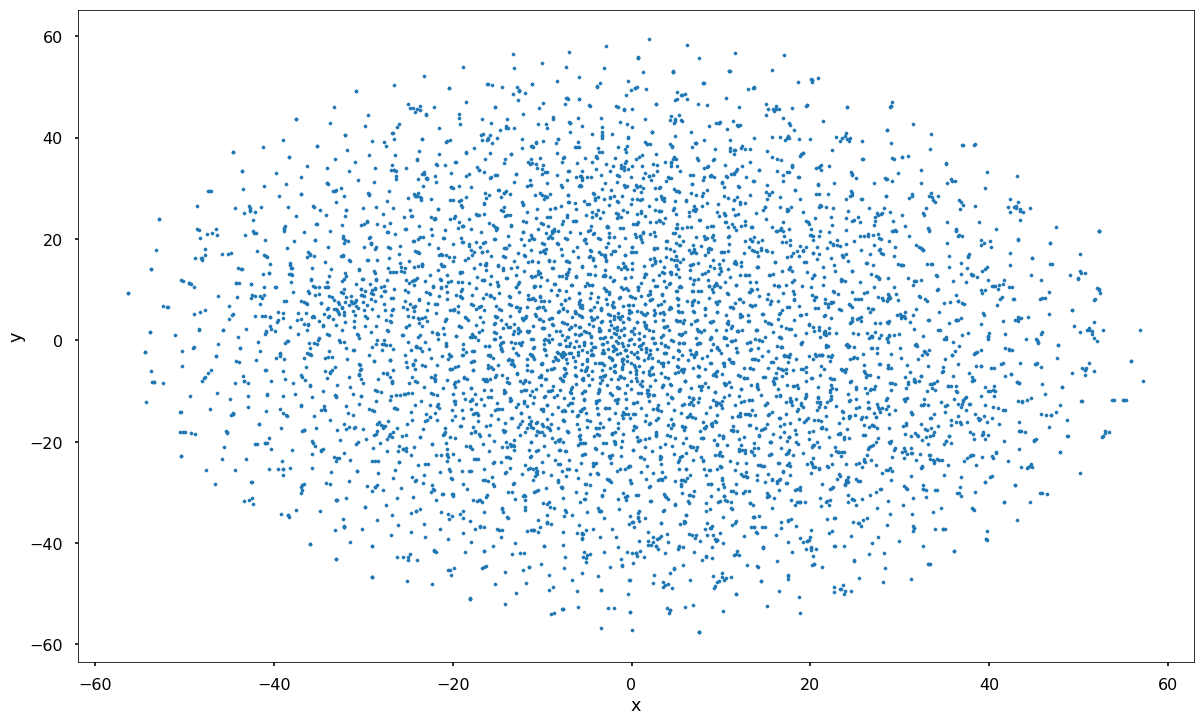

In [21]:
sns.set_context("poster")
ax = points.plot.scatter("x", "y", s=10, figsize=(20, 12))
fig = ax.get_figure()

In [22]:
#Tenserbord adjustment
vocab_list = points.word.values.tolist()
embeddings = all_word_vectors_matrix

embedding_var = tf.Variable(all_word_vectors_matrix,dtype="float32",name="embedding")
projector_config = projector.ProjectorConfig()

embedding = projector_config.embeddings.add()
embedding.tensor_name = embedding_var.name

LOG_DIR = './'
metadata_file = os.path.join("sample.tsv")

In [23]:
with open(os.path.join(LOG_DIR,metadata_file),"wt") as metadata:
         metadata.writelines("%s\n"% w.encode("utf-8") for w in vocab_list)
embedding.metadata_path = os.path.join(os.getcwd(),metadata_file)

summary_writer = tf.summary.FileWriter(LOG_DIR)
projector.visualize_embeddings(summary_writer,projector_config)

saver = tf.train.Saver([embedding_var])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.save(sess,os.path.join(LOG_DIR,metadata_file+".ckpt"))
    
#After all to see visualazation write this in command prompt : tensorboard --logdir=path/of/the/checkpoint